# Introduction: topic modeling of MLA conference abstracts

[Topic modeling](https://en.wikipedia.org/wiki/Topic_model) computationally analyzes topics within texts. By looking at where and when words occure, topics and their percentages can be predicted. LDA (Latent Dirichlet Allocation) is one method of topic modeling. It is a statistical approach that calculates the chances of words appearing in certain contexts (within documents, or near other words). [Here is a simple introduction to LDA](https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d).
 
## What does this code do?

I'm trying to extract topics from the Medical Library Association's conference abstract dataset. What topics have we talked about over the years?
 
## References

Almost all of this code is taken or adapted from these excellent tutorials at Machine Learning Plus:

[Topic Modeling with Gensim (Python)](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)

[Topic modeling visualization – How to present the results of LDA models?](https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/)

# Setup

## Import libraries

In [1]:
import os
import numpy as np # numpy is for working with arrays
import pandas as pd # pandas is a popular data science library

import gensim # gensim is a topic modeling library
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy # spacy is a natural language processing library

# Plotting tools
import pyLDAvis # for visualizing the topic model
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt #for plots
from matplotlib.lines import Line2D

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

## Import data

In [2]:
# the file is downloadable and browsable at http://bit.ly/mlameetings
mla = pd.read_csv("mla.csv", encoding="latin1")

## Preprocess the text

In [3]:
# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords #nltk is another natural language processing library
stop_words = stopwords.words('english')

# add to the stop words list to remove structured abstract headings
stop_words.extend(["objective", "objectives", "method", "methods", "results", "result", "conclusion"\
                   , "conclusions", "discussion", "poster", "purpose", "presentation", "nan"])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bmyers\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# convert to list
titles_abstracts = mla[["Title", "Abstract"]].values.tolist()

In [5]:
# clean up using gensim simple preprocess (convert to lowercase, remove punctuation, etc)
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

titles_abstracts = list(sent_to_words(titles_abstracts))

In [6]:
# Build the bigram and trigram models
# bigrams are groups of two words that occur together (e.g. "information literacy"), trigrams are groups of three words
bigram = gensim.models.Phrases(titles_abstracts, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[titles_abstracts], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [7]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# lemmatization is converting words to their roots (e.g. "users", "used", "using" -- > "use")
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Remove Stop Words
titles_abstracts = remove_stopwords(titles_abstracts)

# Form Bigrams
titles_abstracts_bigrams = make_bigrams(titles_abstracts)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#!python -m spacy download en #uncomment if there's an error importing the english module, may also need to change from en_core_web_sm to just 'en'
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
titles_abstracts_lemmatized = lemmatization(titles_abstracts_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


# Topic model with Gensim and Mallet

Topic modeling in Gensim is fundamentally built on randomization. [You can read more about that here](https://stackoverflow.com/questions/51956153/gensim-lda-coherence-values-not-reproducible-between-runs/55676447#55676447). I have endeavored to minimize this by providing the same dictionary and model file that I used, however, if you re-run this code without those you may encounter a different model than what I created here.

## Create a dictionary (processed words and how many times they appear) and a corpus (all the processed words).

The dictionary may have a different order if you run this multiple times. To preserve a particular dictionary, save and reload on subsequent runs.

In [8]:
# Create Dictionary
#id2word = corpora.Dictionary(titles_abstracts_lemmatized)

## to be able to reproduce the dictionary, save it on one run and then load it on subsequent runs
#id2word.save("dict.txt")
id2word=corpora.Dictionary.load("dict.txt")

# Create Corpus
texts = titles_abstracts_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

## Get Mallet http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

In [9]:
# updating environment, change this to reflect where mallet is on your own computer
%env 'MALLET_HOME': "C:/Users/bmyers/Desktop/mallet-2.0.8"
os.environ.update({'MALLET_HOME':r"C:/Users/bmyers/Desktop/mallet-2.0.8"})

env: 'MALLET_HOME':="C:/Users/bmyers/Desktop/mallet-2.0.8"


In [10]:
# also change this to point to this same directory on your own computer
mallet_path = "C:/Users/bmyers/Desktop/mallet-2.0.8/bin/mallet"

## Create Gensim LDA model, convert to Mallet

In [22]:
# create a gensim LDA model

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=16, #more on choosing a number of topics below. don't forget to update here
                                           random_state=100,
                                           update_every=1,
                                           chunksize=200,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True) 

# change to a mallet model, mallet uses a different algorithm and in this case is giving better topics
# don't forget to update # of topics here
# setting the random seed ensures that this is reproducible
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=16, id2word=id2word, random_seed=1) 

doc_lda = lda_model[corpus]

In [28]:
### save the model - comment out to regenerate
ldamallet.save("model.txt")

In [19]:
### load the model - comment out if using a recreated model
# ldamallet.load("model.txt")

In [24]:
# view the mallet topics
print(ldamallet.show_topics(formatted=False))

[(12, [('research', 0.0818582218277427), ('support', 0.03104851539865691), ('researcher', 0.027414465861705158), ('team', 0.027380972317585784), ('project', 0.0252876258101251), ('develop', 0.021486108552576492), ('management', 0.019057826603922093), ('collaboration', 0.01758411066266977), ('development', 0.01590943345670122), ('university', 0.015507510927268769)]), (5, [('student', 0.1424420756532682), ('faculty', 0.05951587830335332), ('medical', 0.05773928492116367), ('school', 0.04511806943519135), ('year', 0.03223776741431638), ('curriculum', 0.02835146939077652), ('skill', 0.02089347842179288), ('program', 0.014249759419646162), ('graduate', 0.013953660522614554), ('instruction', 0.013879635798356651)]), (15, [('library', 0.2829354994103088), ('service', 0.11003139482732845), ('staff', 0.04845434461221575), ('science', 0.03521536187106526), ('academic', 0.02656102058105347), ('reference', 0.02119566120164117), ('campus', 0.016943240145512534), ('provide', 0.01651135363199947), ('

### Calculate coherence score to evaluate quality of model

In [25]:
# Calcuate the coherence score for the mallet topics we just identified
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=texts, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.4586964974512744


## Detour to figure out how many topics are optimal. 

Too many, they overlap and are too specific to really represent overall trends; too few, and we miss identifying key themes. We can check the coherence scores of topics to see how similar the words in each topic are to each other.

These code sections are in RawNB Convert form, change them to Code in the dropdown menu at the top if you want to be able to run these for yourself.

If, based on this next section, you change your mind about the optimal number of topics, don't forget to update the arguments for the lda_model and ldamallet variables above.

# Visualize topic model with pyLDAvis

In [26]:
# switch the mallet model back to a gensim model as pyLDAvis doesn't work directly with mallet
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

In [27]:
# code gives a warning (was supposed to have been fixed in the latest version of pyLDAvis) but it still works
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, id2word, sort_topics=False)
pyLDAvis.display(vis)

C:\Users\bmyers\AppData\Local\Continuum\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
C:\Users\bmyers\AppData\Local\Continuum\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
C:\Users\bmyers\AppData\Local\Continuum\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
C:\Users\bmyers\AppData\Local\Continuum\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] 

In [30]:
# save the visualization
pyLDAvis.save_html(vis, 'mla_topics.html')

# Analyze dominant topics

In [31]:
# go through the abstracts and select the most dominant topic in each abstract
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=titles_abstracts_lemmatized):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=titles_abstracts_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
#display(df_dominant_topic)

## Incorporate year data to see trends over time

In [32]:
# add years
df_dominant_topic["Year"] = mla["Year"]

# Show
# display(df_dominant_topic)

## Change the numerical topic codes to human-readable topics and adjust the formatting of the model data

In [33]:
# the model data is a list of tuples, each tuple is the topic number 
# along with the percentage of contribution that that topic makes to each record

# turning that into a formatted dataframe that has each topic as a column and the values are the percentages
    
tuples_as_df = pd.DataFrame(ldamallet[corpus])

# rename columns
tuples_as_df["Events"] = tuples_as_df[0].str[1]
tuples_as_df["Electronic resources"] = tuples_as_df[1].str[1]
tuples_as_df["Publications"] = tuples_as_df[2].str[1]
tuples_as_df["Evidence-based practice"] = tuples_as_df[3].str[1]
tuples_as_df["Collections"] = tuples_as_df[4].str[1]
tuples_as_df["Academic instruction"] = tuples_as_df[5].str[1]
tuples_as_df["Librarian roles and relationships"] = tuples_as_df[6].str[1]
tuples_as_df["Technical systems"] = tuples_as_df[7].str[1]
tuples_as_df["Special collections"] = tuples_as_df[8].str[1]
tuples_as_df["General instruction"] = tuples_as_df[9].str[1]
tuples_as_df["Literature searching"] = tuples_as_df[10].str[1]
tuples_as_df["Surveys"] = tuples_as_df[11].str[1]
tuples_as_df["Research support"] = tuples_as_df[12].str[1]
tuples_as_df["Community outreach"] = tuples_as_df[13].str[1]
tuples_as_df["Patient education"] = tuples_as_df[14].str[1]
tuples_as_df["Library services"] = tuples_as_df[15].str[1]


tuples_as_df.drop(tuples_as_df.iloc[:, 0:16], inplace=True, axis=1)
# display(tuples_as_df)


## Merge the model's full data with the dominant topic dataframe from before. Now all data is in one place

In [34]:
all_topics = pd.concat([tuples_as_df, df_dominant_topic], axis=1)

## Rename the dominant topics in the cells from numbers to topic names

In [35]:
all_topics["Dominant_Topic"].loc[all_topics["Dominant_Topic"] == 0.0] = "Events"
all_topics["Dominant_Topic"].loc[all_topics["Dominant_Topic"] == 1.0] = "Electronic resources"
all_topics["Dominant_Topic"].loc[all_topics["Dominant_Topic"] == 2.0] = "Publications"
all_topics["Dominant_Topic"].loc[all_topics["Dominant_Topic"] == 3.0] = "Evidence-based practice"
all_topics["Dominant_Topic"].loc[all_topics["Dominant_Topic"] == 4.0] = "Collections"
all_topics["Dominant_Topic"].loc[all_topics["Dominant_Topic"] == 5.0] = "Academic instruction"
all_topics["Dominant_Topic"].loc[all_topics["Dominant_Topic"] == 6.0] = "Librarian roles and relationships"
all_topics["Dominant_Topic"].loc[all_topics["Dominant_Topic"] == 7.0] = "Technical systems"
all_topics["Dominant_Topic"].loc[all_topics["Dominant_Topic"] == 8.0] = "Special collections"
all_topics["Dominant_Topic"].loc[all_topics["Dominant_Topic"] == 9.0] = "General instruction"
all_topics["Dominant_Topic"].loc[all_topics["Dominant_Topic"] == 10.0] = "Literature searching"
all_topics["Dominant_Topic"].loc[all_topics["Dominant_Topic"] == 11.0] = "Surveys"
all_topics["Dominant_Topic"].loc[all_topics["Dominant_Topic"] == 12.0] = "Research support"
all_topics["Dominant_Topic"].loc[all_topics["Dominant_Topic"] == 13.0] = "Community outreach"
all_topics["Dominant_Topic"].loc[all_topics["Dominant_Topic"] == 14.0] = "Patient education"
all_topics["Dominant_Topic"].loc[all_topics["Dominant_Topic"] == 15.0] = "Library services"

# display(all_topics)

C:\Users\bmyers\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


## Plot topics that most dominate presentations

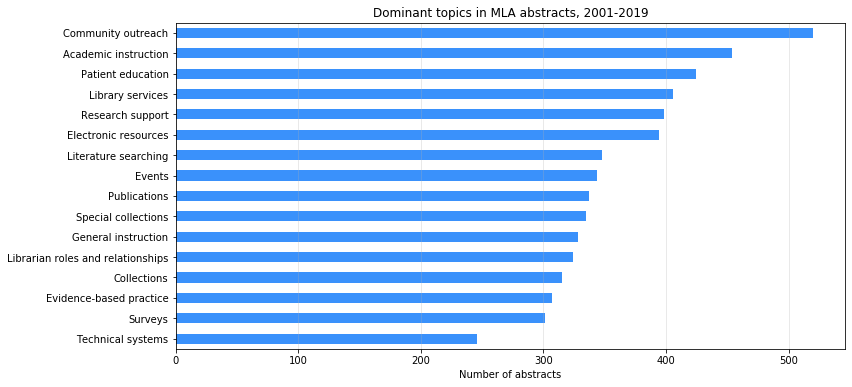

In [96]:
# pull out the dominant topic column from the dataframe, count each occurence of each topic, and sort
all_topics_dominant = all_topics["Dominant_Topic"].value_counts()
all_topics_dominant = all_topics_dominant.sort_values(ascending = True)
# transpose so that the topics are on the y axis
all_topics_dominant = all_topics_dominant.T

# plot
ax = all_topics_dominant.plot.barh(figsize=(12,6), color="#3a91fb", title="Dominant topics in MLA abstracts, 2001-2019")
ax.grid(axis="x", alpha=.35)
ax.set(xlabel="Number of abstracts")

fig = ax.get_figure()
fig.savefig("most dominant topics in each mla abstract", dpi =1000)

## Plot distribution of the topic percentages through time

In [37]:
# create new dataframe

topics_over_time = all_topics.groupby(['Year'])[["Events",
"Electronic resources",
"Publications",
"Evidence-based practice",
"Collections",
"Academic instruction",
"Librarian roles and relationships",
"Technical systems",
"Special collections",
"General instruction",
"Literature searching",
"Surveys",
"Research support",
"Community outreach",
"Patient education",
"Library services"]].sum()
#display(topics_over_time)

#### Area plot

This plot shows the percentage of each topic within each year's total amount of content

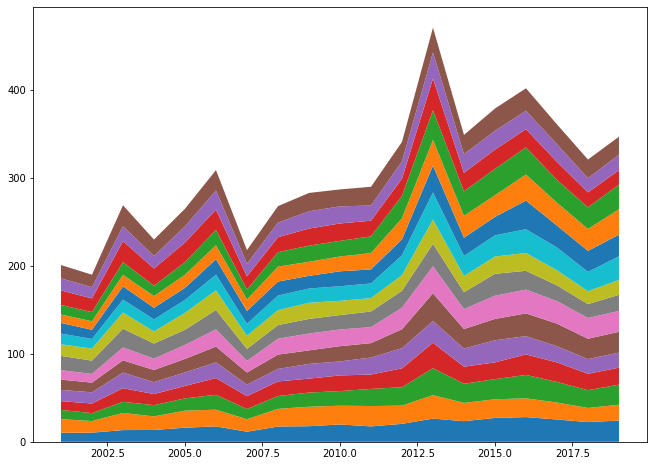

In [39]:
fig, ax = plt.subplots()
fig.set_size_inches(11,8)

y = [topics_over_time["Events"],
topics_over_time["Electronic resources"],
topics_over_time["Publications"],
topics_over_time["Evidence-based practice"],
topics_over_time["Collections"],
topics_over_time["Academic instruction"],
topics_over_time["Librarian roles and relationships"],
topics_over_time["Technical systems"],
topics_over_time["Special collections"],
topics_over_time["General instruction"],
topics_over_time["Literature searching"],
topics_over_time["Surveys"],
topics_over_time["Research support"],
topics_over_time["Community outreach"],
topics_over_time["Patient education"],
topics_over_time["Library services"],  
    ]

# can't get legends to work on stackplot
ax.stackplot(topics_over_time.index, y)
plt.show()

#### 100% area plot

This plot normalizes the topics to show the relative percentage of each topic over all 19 years

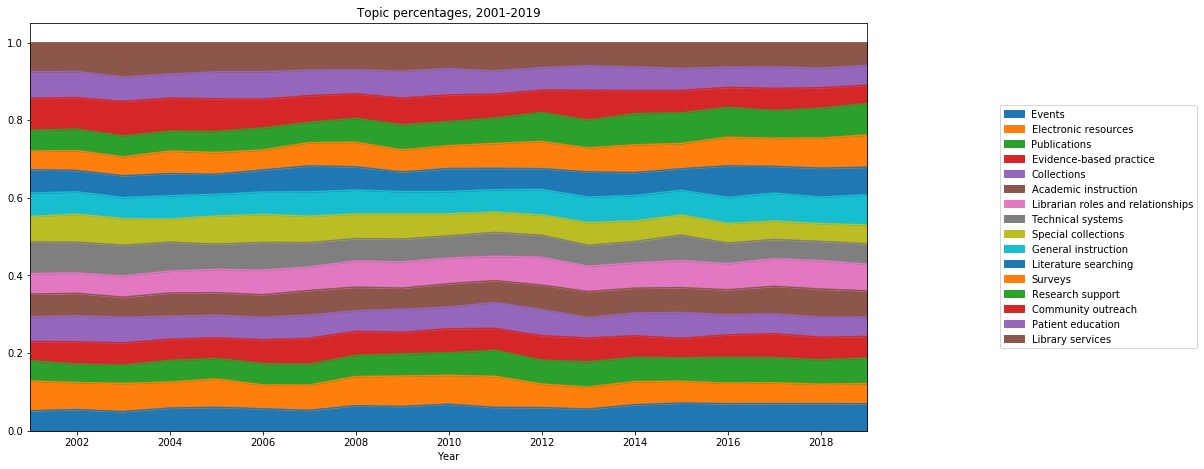

In [41]:
topics_over_time_plot = topics_over_time.divide(topics_over_time.sum(axis=1), axis=0)

ax2 = topics_over_time_plot.plot.area(figsize=(15,7.5), title="Topic percentages, 2001-2019")
fig2 = ax2.get_figure()
ax2.legend(loc='center right', bbox_to_anchor=(1.4,.5))
fig2.savefig("area plot.png", dpi =1000)

#### Single topic plot - relative

This plot shows what % per year this one topic represents compared to the other 26 topics

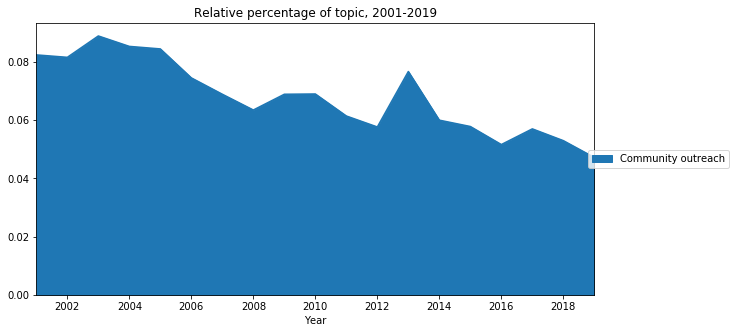

In [97]:
ax3 = topics_over_time_plot["Community outreach"].plot.area(figsize=(10,5), title="Relative percentage of topic, 2001-2019")
fig3 = ax3.get_figure()
ax3.legend(loc='center right', bbox_to_anchor=(1.25,.5))

#### Single topic plot - absolute

This plot shows the topic's % per year representation in all meeting content

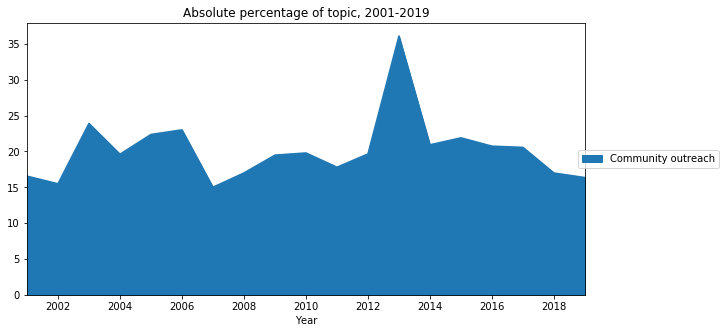

In [98]:
ax4 = topics_over_time["Community outreach"].plot.area(figsize=(10,5), title="Absolute percentage of topic, 2001-2019")
fig4 = ax4.get_figure()
ax4.legend(loc='center right', bbox_to_anchor=(1.25,.5))

## Analyze topic changes over time

### Print the min & max absolute value and the year in which it happened for each topic (i.e. the actual topic representation %)

In [90]:
# year when each topic was most represented - absolutely
print("Maximum absolute topic representation amount:\n") #the sum of all topic contributions for the year in which it was the highest
print(topics_over_time.max())
print("\nMaximum absolute topic representation amount year:\n") # the year corresponding to the highest % amount
print(topics_over_time.idxmax())
print("----------------------")
print("Minimum absolute topic representation amount:\n") #the sum of all topic contributions for the year in which it was the lowest
print(topics_over_time.min())
print("\nMinimum absolute topic representation amount year:\n") # the year corresponding to the lowest % amount
print(topics_over_time.idxmin())

Maximum absolute topic representation amount:

Events                               28.098564
Electronic resources                 26.617459
Publications                         30.632434
Evidence-based practice              28.951018
Collections                          25.155879
Academic instruction                 31.549406
Librarian roles and relationships    30.739697
Technical systems                    25.488323
Special collections                  27.615426
General instruction                  30.812699
Literature searching                 32.569019
Surveys                              29.633483
Research support                     33.751784
Community outreach                   36.121690
Patient education                    29.702667
Library services                     28.243945
dtype: float64

Maximum absolute topic representation amount year:

Events                               2016
Electronic resources                 2013
Publications                         2013
Evidenc

### Print the maximum relative value and the year in which it happened for each topic (i.e. the topics have been normalized so that all the topics for each year add up to 1)

In [91]:
# years when each topic was most represented - relatively

print("Maximum relative topic representation amount:\n") #the sum of all topic contributions for the year in which it was the highest
print(topics_over_time_plot.max())
print("\nMaximum relative topic representation amount year:\n") # the year corresponding to the highest % amount
print(topics_over_time_plot.idxmax())
print("----------------------")
print("Minimum relative topic representation amount:\n") #the sum of all topic contributions for the year in which it was the lowest
print(topics_over_time_plot.min())
print("\nMinimum relative topic representation amount year:\n") # the year corresponding to the lowest % amount
print(topics_over_time_plot.idxmin())

Maximum relative topic representation amount:

Events                               0.071618
Electronic resources                 0.079822
Publications                         0.067139
Evidence-based practice              0.066808
Collections                          0.067189
Academic instruction                 0.072199
Librarian roles and relationships    0.073467
Technical systems                    0.081227
Special collections                  0.072425
General instruction                  0.077889
Literature searching                 0.081017
Surveys                              0.082925
Research support                     0.081124
Community outreach                   0.088901
Patient education                    0.070632
Library services                     0.088713
dtype: float64

Maximum relative topic representation amount year:

Events                               2015
Electronic resources                 2011
Publications                         2011
Evidence-based practice

## Plot high and low relative values over time

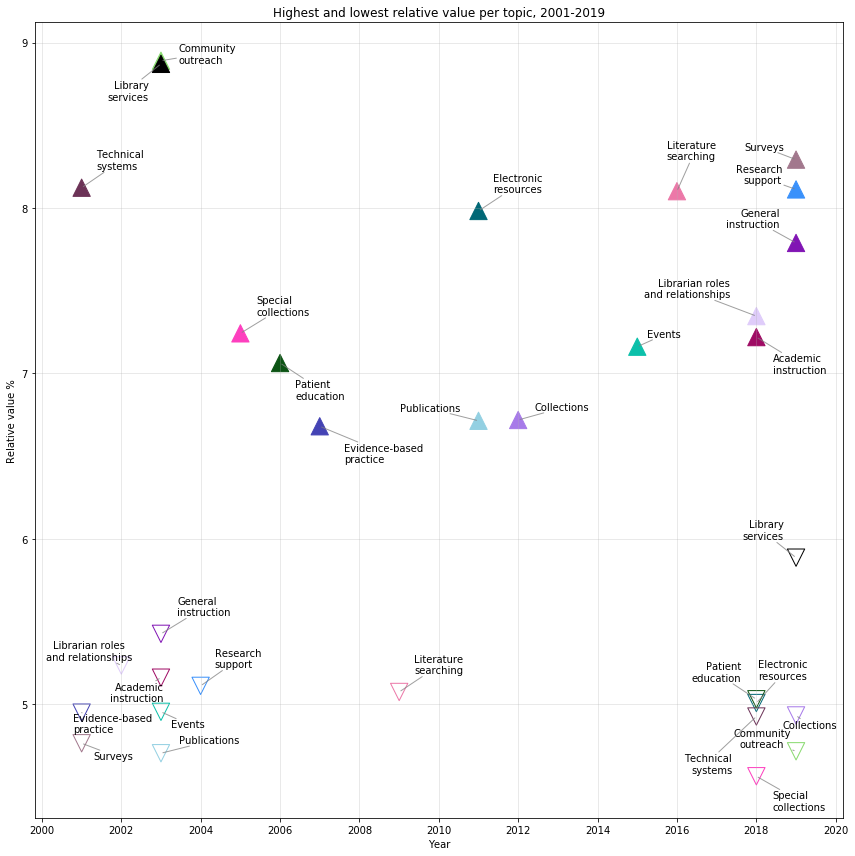

<Figure size 864x864 with 0 Axes>

In [94]:
from adjustText import adjust_text #this library helps automatically adjust the scatterplot labels

# new dataframe for high and low values
high_rel = pd.DataFrame()
high_rel["Value"] = topics_over_time_plot.max()
high_rel["Year"] = topics_over_time_plot.idxmax()
high_rel['Topic'] = high_rel.index

low_rel = pd.DataFrame()
low_rel["Value"] = topics_over_time_plot.min()
low_rel["Year"] = topics_over_time_plot.idxmin()
low_rel['Topic'] = low_rel.index

#display(high_rel)
#display(low_rel)

#make list of colors for graph
cmap = ["#0cc0aa","#016876","#93d0e2","#4443b4","#a77ae9",
        "#9f0b64","#dfccfa","#6c3357","#fd3fbe","#8115b4",
        "#ec78a8","#a2788d","#3a91fb","#88da6f","#0b5313", "#000000"]

#make list of label names for graph
topiclist = ["Events",
"Electronic\nresources",
"Publications",
"Evidence-based\npractice",
"Collections",
"Academic\ninstruction",
"Librarian roles\nand relationships",
"Technical\nsystems",
"Special\ncollections",
"General\ninstruction",
"Literature\nsearching",
"Surveys",
"Research\nsupport",
"Community\noutreach",
"Patient\neducation",
"Library\nservices"]

#convert the year to a date
high_rel["Year"] = pd.to_datetime(high_rel["Year"], format='%Y')
low_rel["Year"] = pd.to_datetime(low_rel["Year"], format='%Y')

#convert value to percentage
high_rel["Value"] = high_rel["Value"] * 100
low_rel["Value"] = low_rel["Value"] * 100

#plotting
fig, ax = plt.subplots(figsize=(12,12))
ax.grid(alpha=.35)

highs = ax.scatter(high_rel["Year"], high_rel["Value"], c=cmap, s=300, marker="^")
lows = ax.scatter(low_rel["Year"], low_rel["Value"], edgecolors=cmap, s=300, marker="v", facecolors='none')

ax.set_title("Highest and lowest relative value per topic, 2001-2019")

textshigh = [plt.annotate(label,xy=(x, y)) for label, x, y in zip(topiclist, high_rel["Year"], high_rel["Value"])]
adjust_text(textshigh, expand_text=(1.0, 1.0), expand_points=(1.5, 2.25), arrowprops=dict(arrowstyle='-', color='gray', alpha=.75))
textslow = [plt.annotate(label,xy=(x, y)) for label, x, y in zip(topiclist, low_rel["Year"], low_rel["Value"])]
adjust_text(textslow, expand_text=(1.0, 1.0), expand_points=(1.5, 2.25), arrowprops=dict(arrowstyle='-', color='gray', alpha=.75))

ax.set(xlabel="Year")
ax.set(ylabel="Relative value %")

plt.tight_layout()
plt.show()

fig = plt.gcf()
fig.set_size_inches(12,12)
fig = ax.get_figure()
fig.savefig('highest and lowest relative values per topic.png', dpi=300)